<a href="https://colab.research.google.com/github/Yoethan64/Airfoil-Lift-Predictor/blob/main/aeroo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
project_path = '/content/drive/MyDrive/aeroo'
os.makedirs(project_path, exist_ok=True)
print("Project folder ready:", project_path)

Project folder ready: /content/drive/MyDrive/aeroo


In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
OpenCV version: 4.12.0


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/aeroo/data/coord_seligFmt.zip'
extract_path = '/content/drive/MyDrive/aeroo/data/coordinates/'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List .dat files
dat_files = [f for f in os.listdir(extract_path+'/coord_seligFmt/') if f.endswith('.dat')]
print(f"Found {len(dat_files)} airfoils")  # Expect ~1650

Found 1647 airfoils


<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3674669982.py:24: SyntaxWarning: invalid escape sequence '\d'
  l[i] = re.findall("[-+]?\d*\.\d+|\d+", l[i])


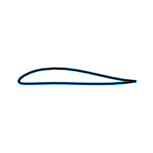

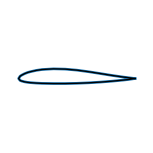

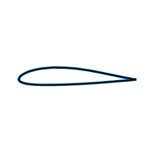

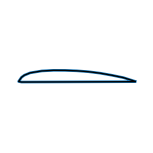

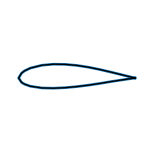

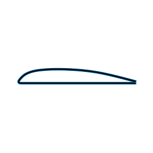

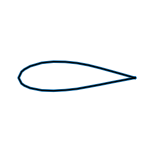

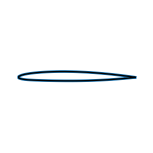

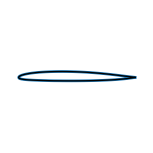

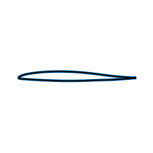

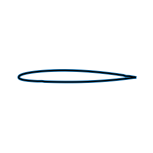

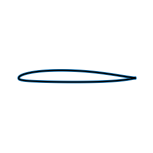

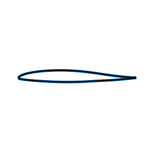

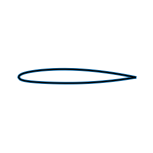

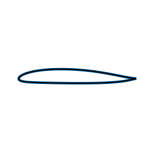

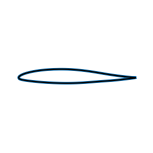

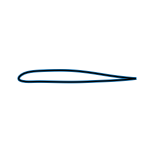

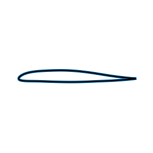

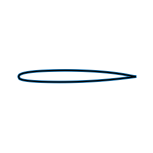

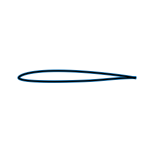

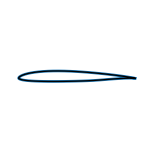

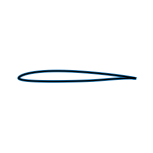

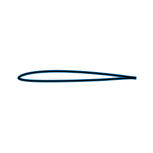

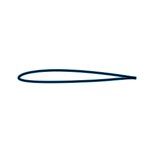

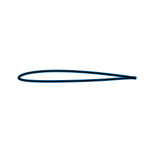

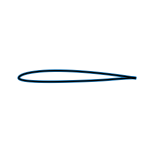

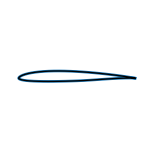

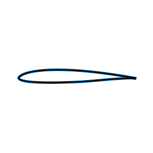

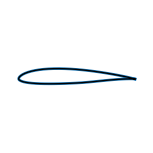

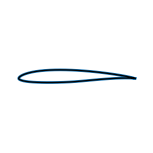

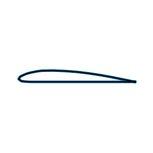

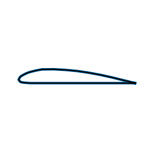

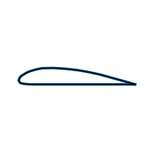

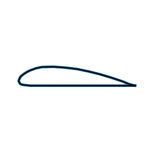

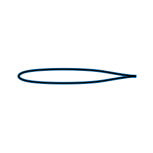

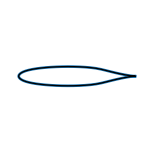

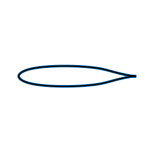

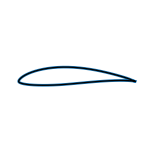

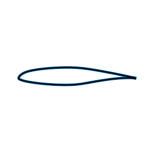

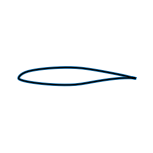

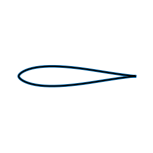

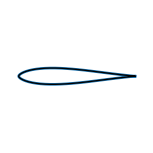

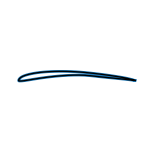

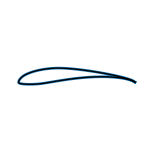

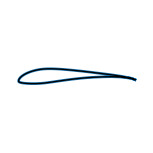

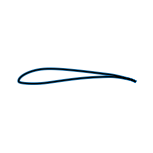

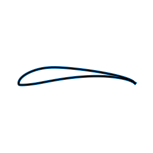

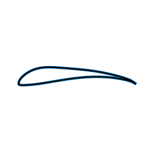

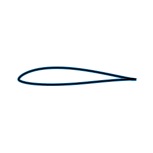

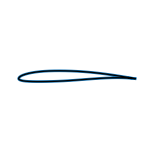

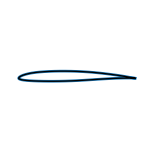

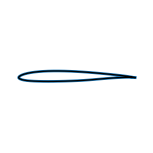

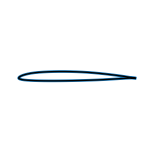

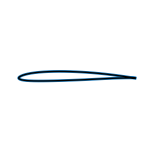

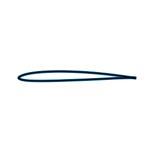

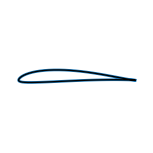

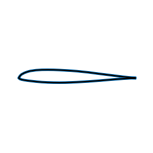

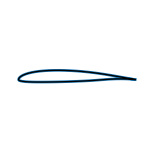

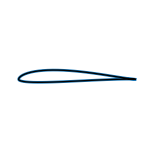

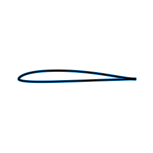

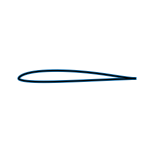

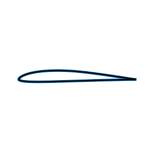

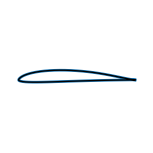

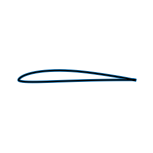

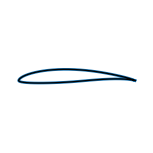

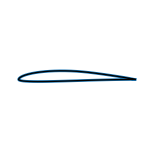

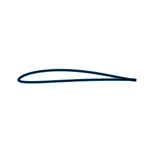

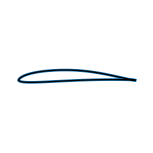

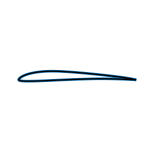

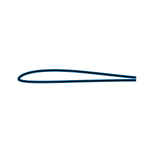

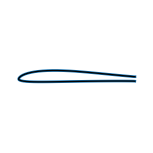

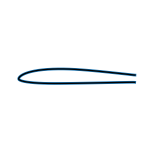

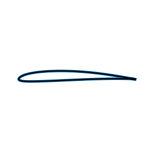

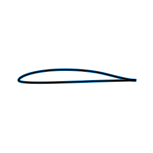

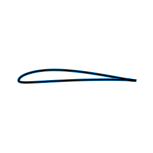

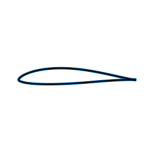

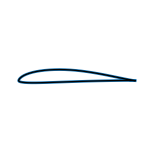

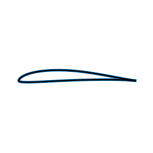

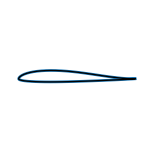

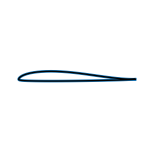

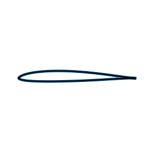

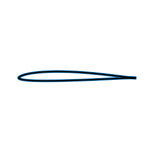

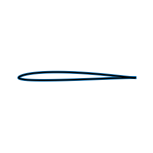

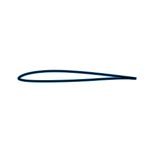

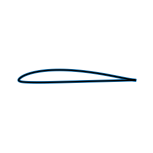

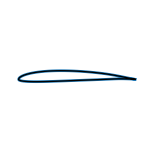

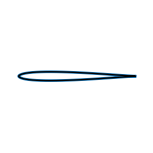

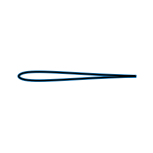

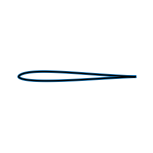

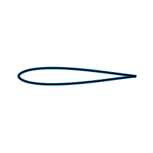

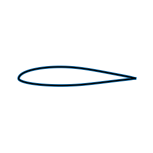

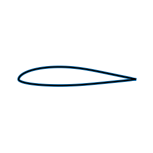

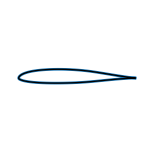

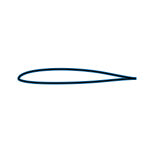

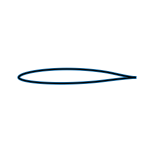

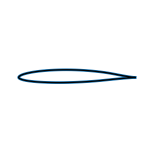

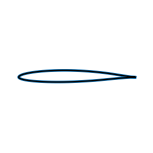

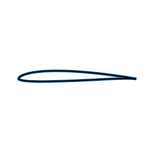

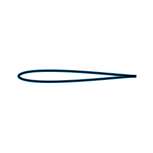

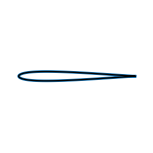

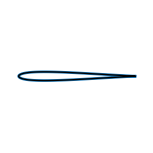

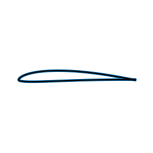

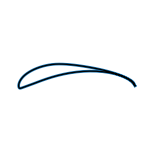

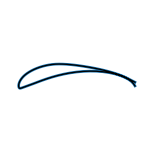

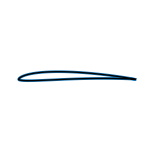

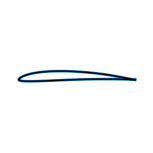

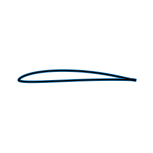

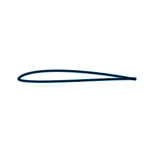

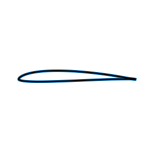

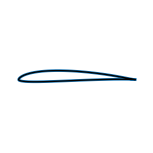

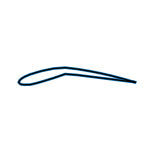

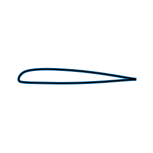

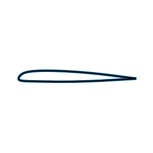

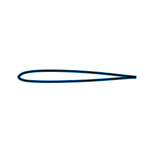

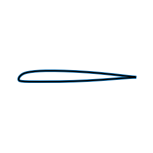

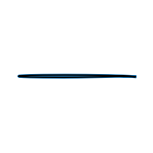

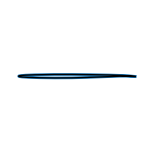

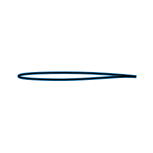

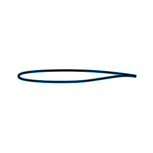

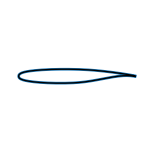

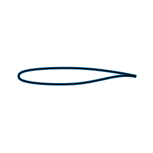

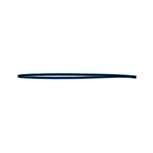

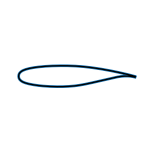

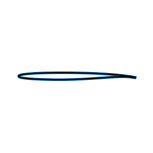

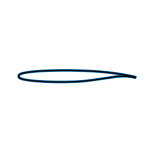

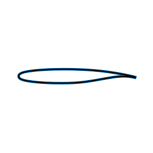

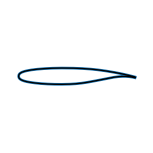

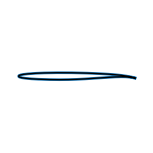

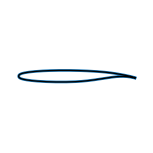

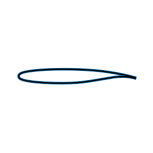

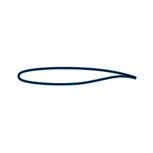

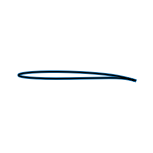

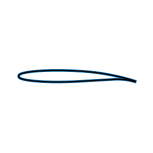

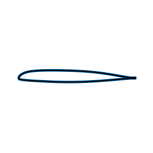

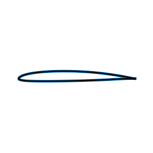

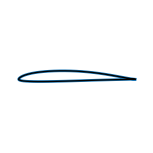

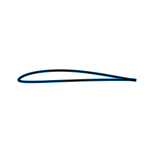

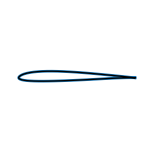

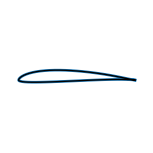

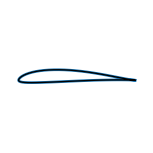

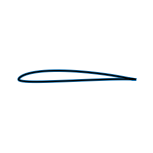

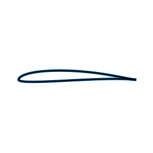

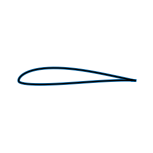

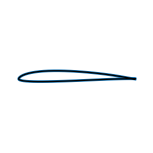

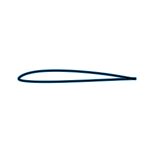

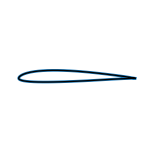

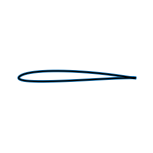

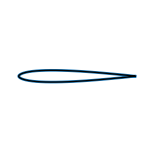

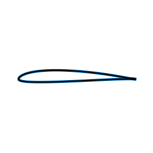

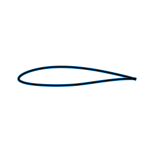

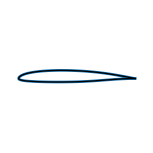

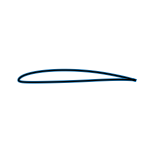

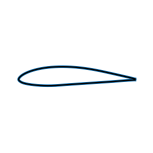

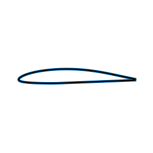

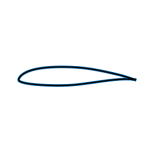

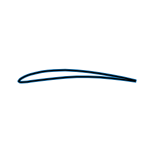

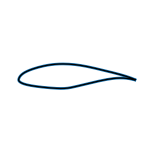

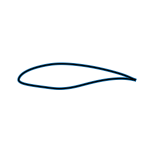

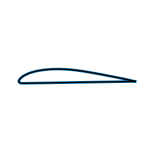

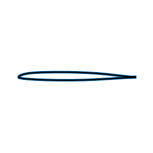

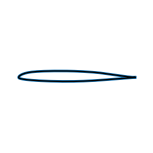

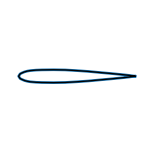

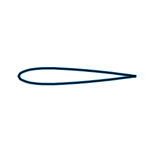

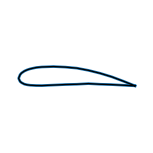

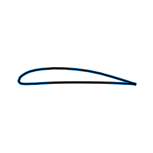

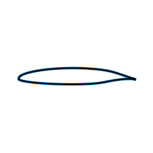

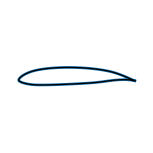

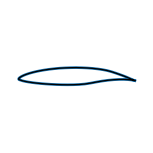

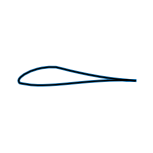

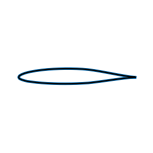

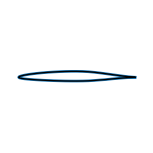

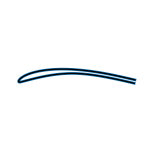

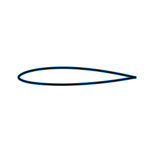

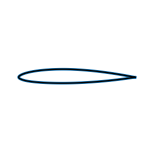

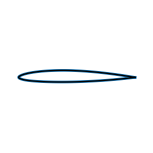

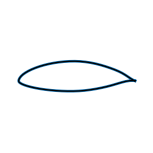

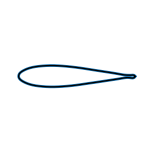

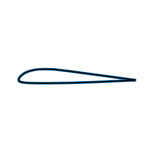

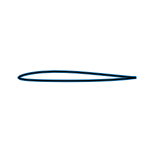

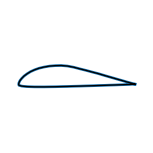

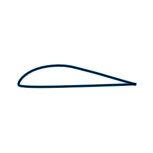

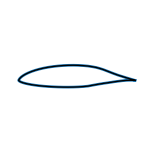

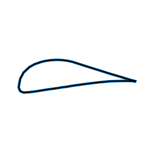

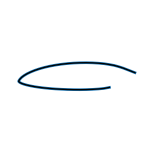

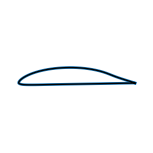

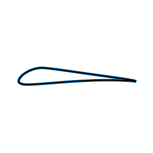

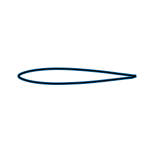

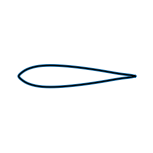

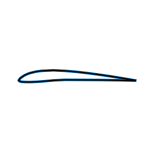

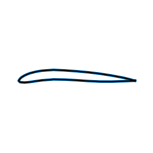

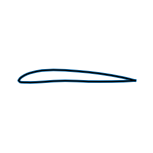

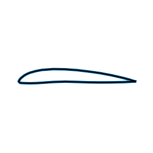

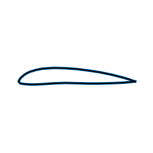

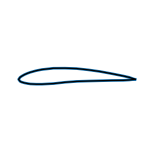

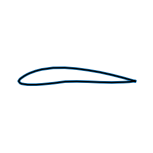

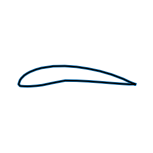

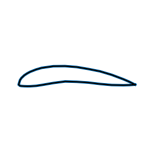

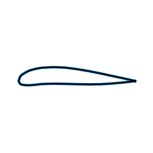

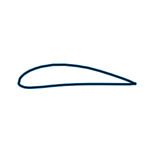

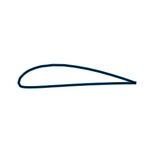

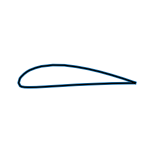

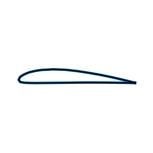

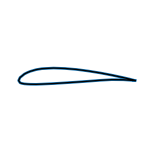

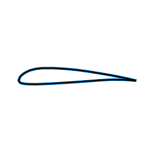

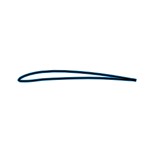

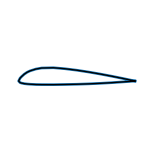

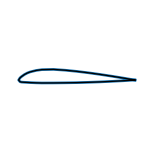

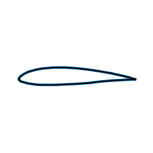

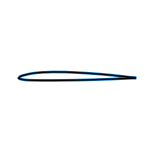

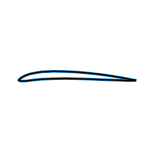

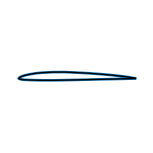

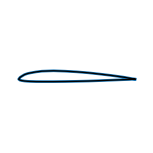

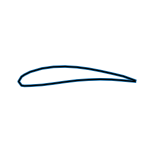

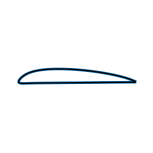

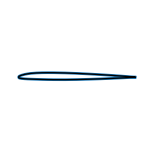

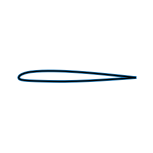

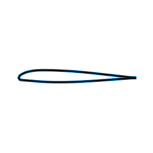

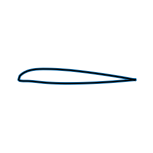

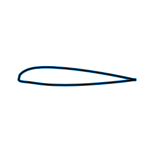

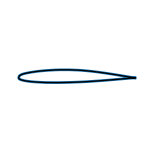

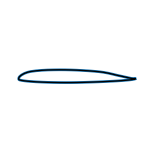

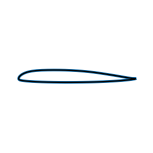

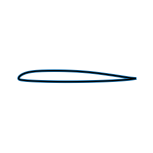

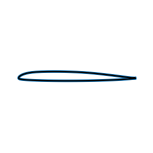

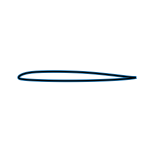

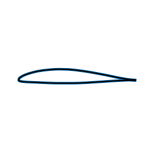

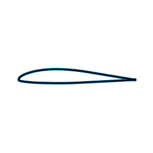

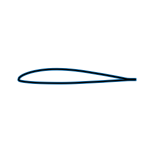

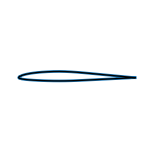

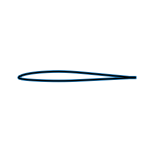

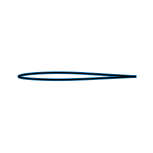

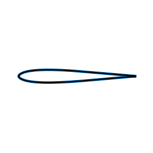

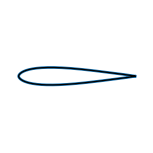

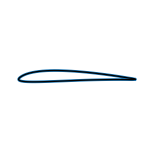

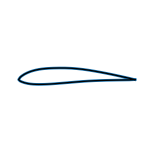

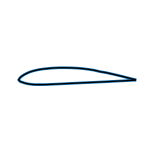

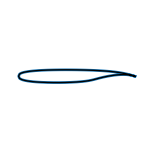

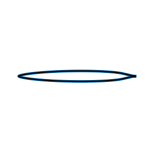

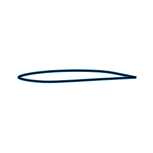

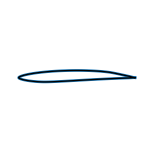

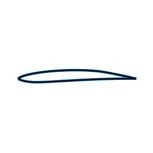

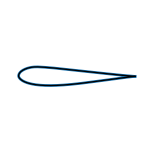

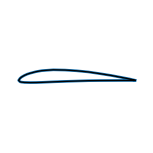

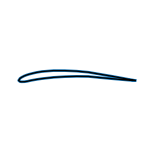

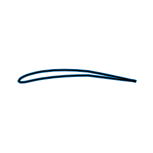

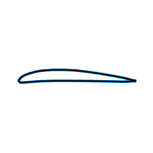

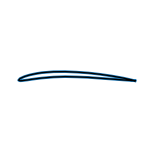

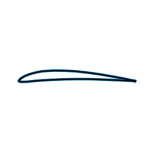

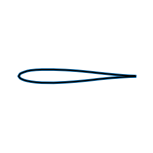

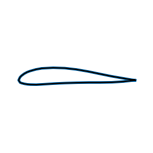

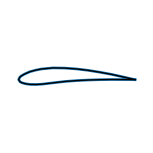

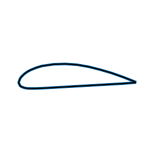

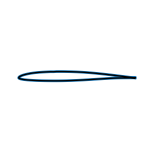

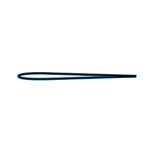

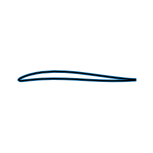

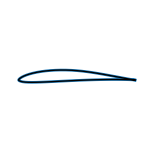

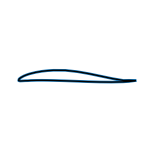

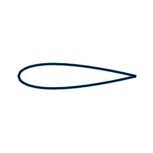

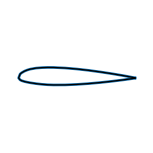

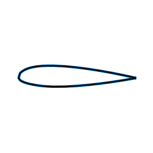

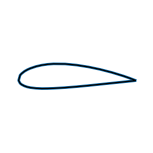

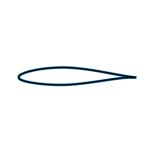

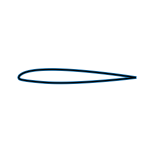

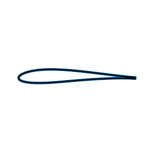

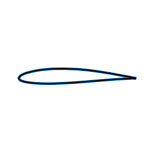

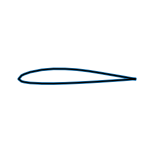

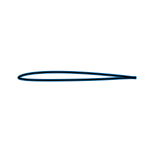

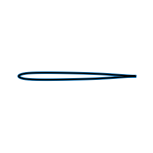

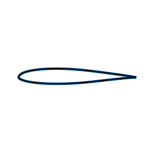

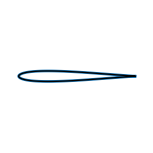

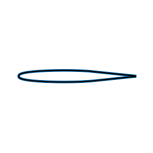

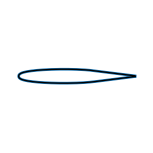

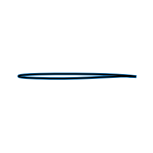

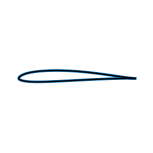

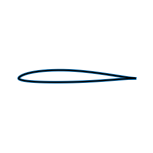

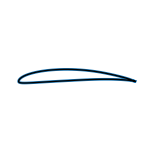

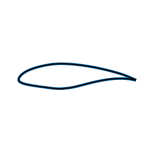

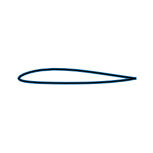

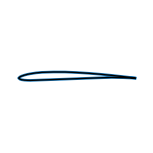

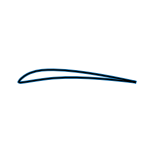

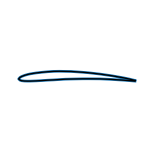

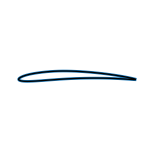

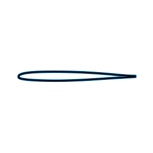

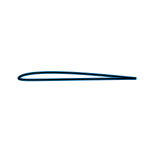

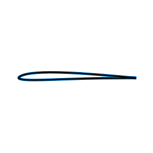

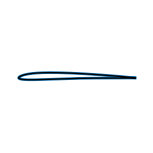

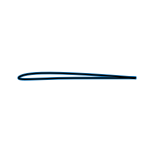

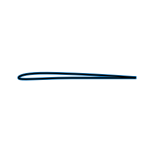

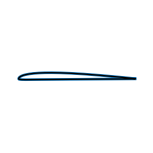

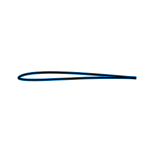

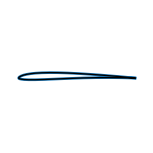

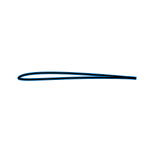

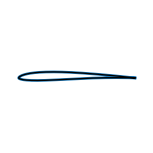

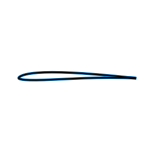

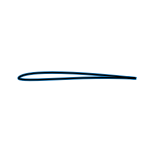

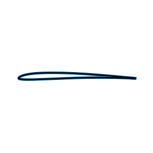

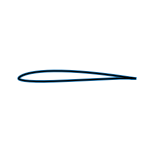

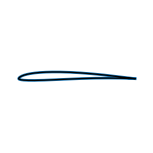

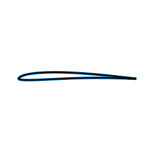

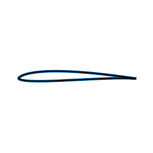

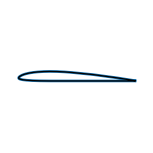

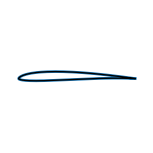

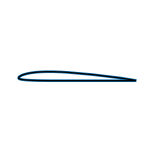

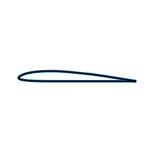

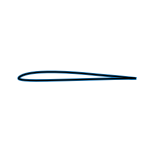

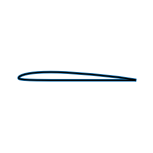

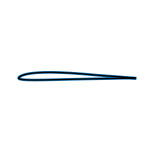

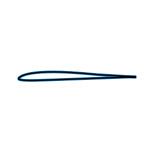

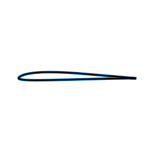

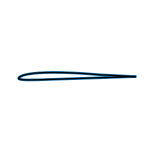

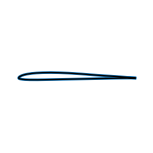

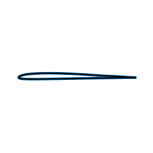

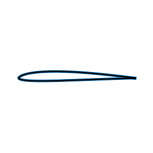

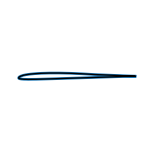

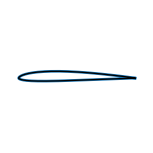

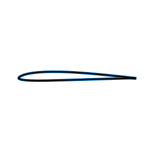

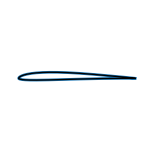

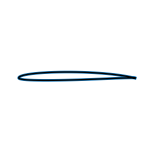

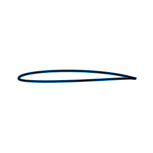

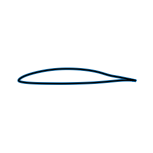

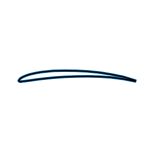

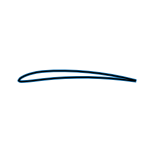

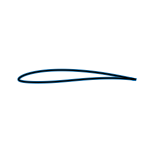

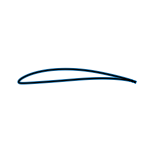

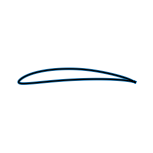

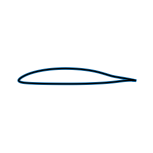

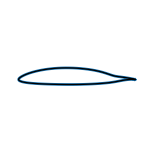

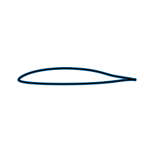

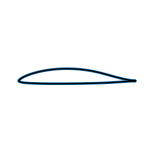

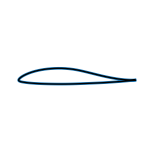

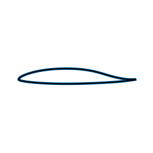

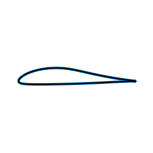

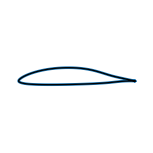

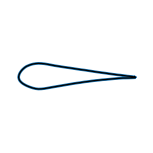

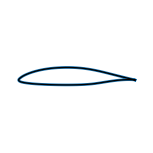

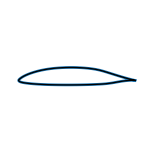

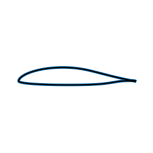

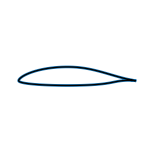

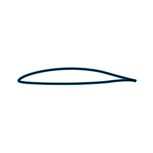

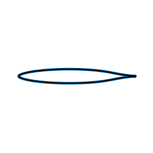

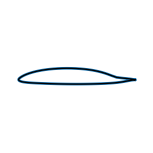

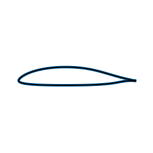

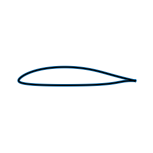

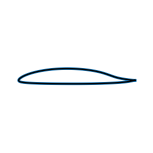

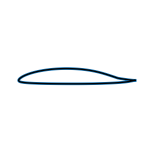

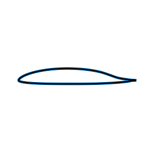

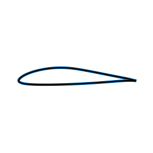

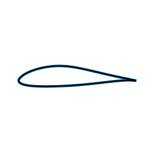

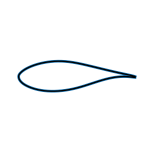

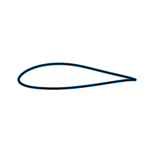

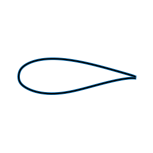

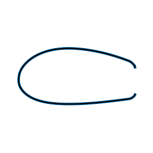

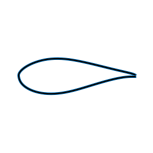

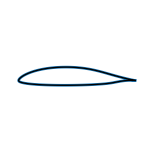

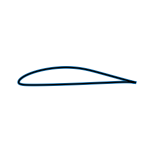

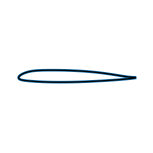

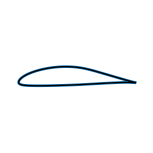

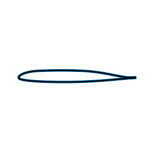

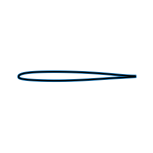

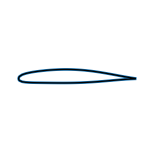

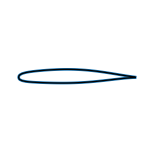

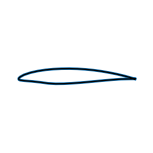

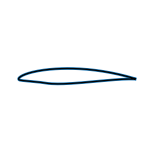

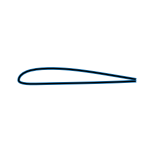

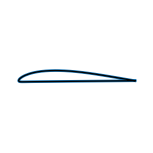

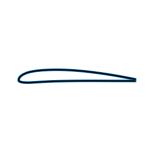

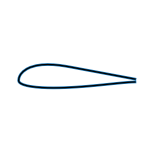

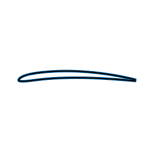

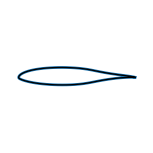

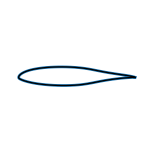

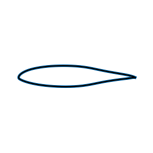

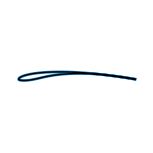

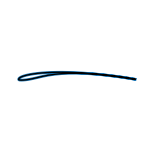

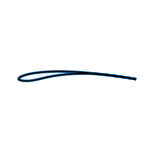

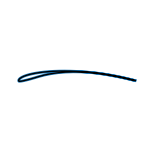

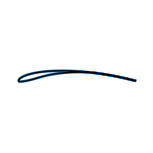

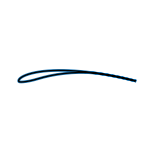

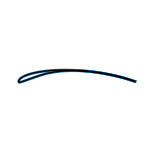

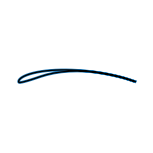

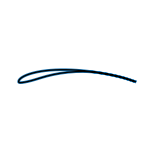

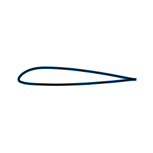

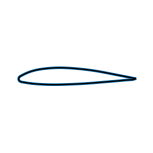

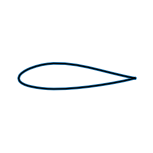

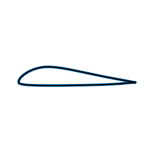

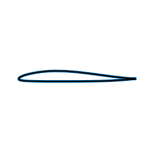

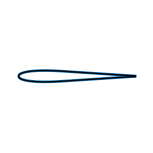

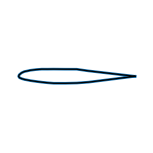

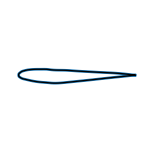

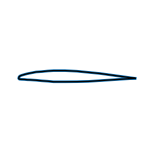

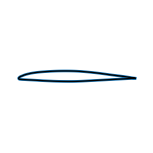

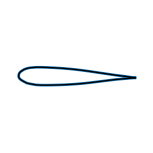

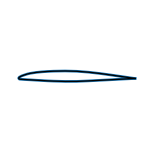

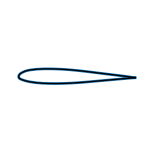

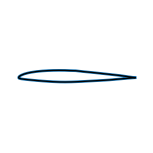

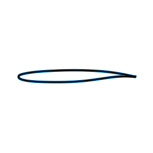

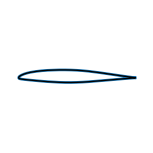

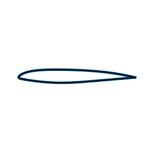

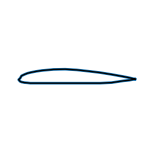

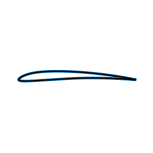

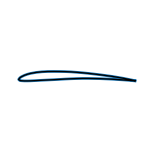

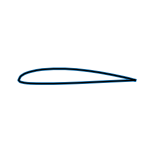

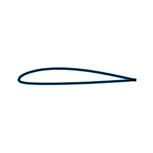

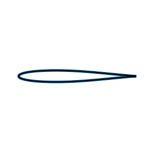

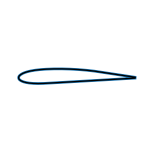

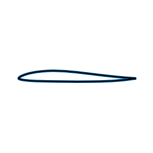

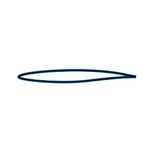

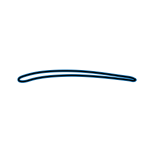

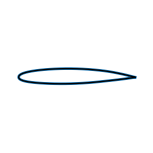

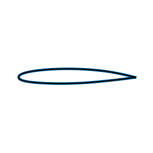

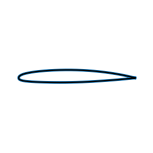

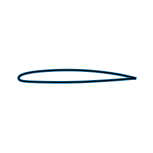

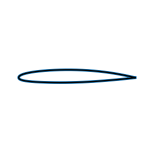

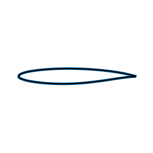

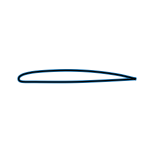

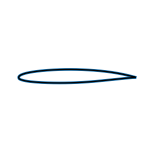

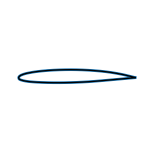

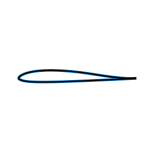

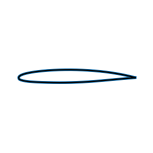

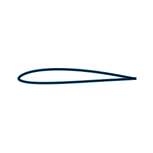

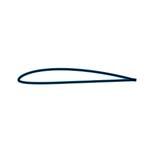

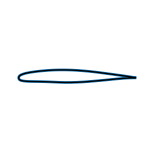

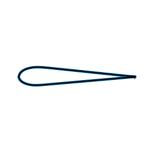

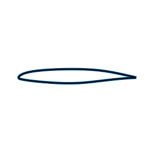

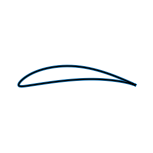

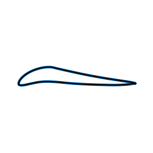

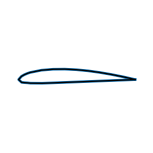

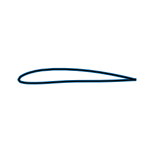

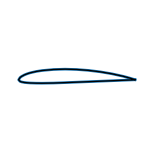

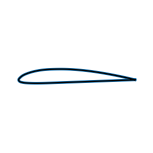

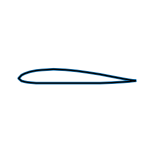

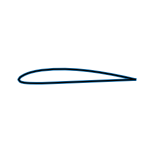

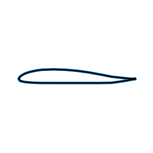

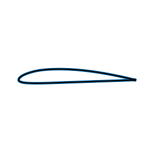

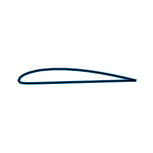

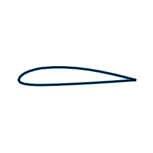

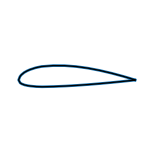

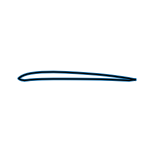

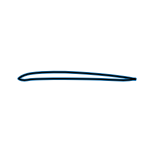

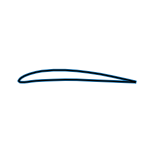

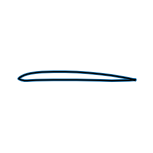

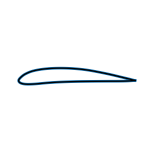

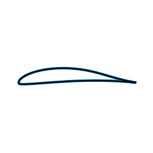

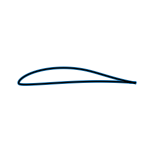

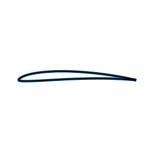

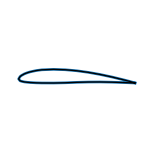

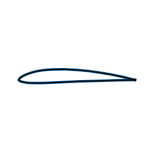

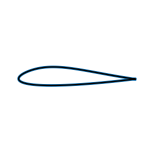

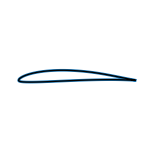

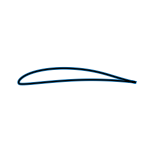

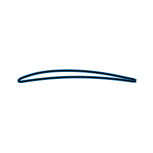

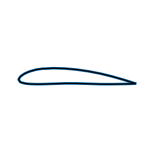

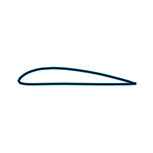

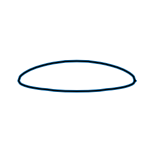

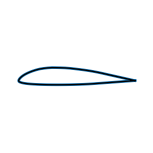

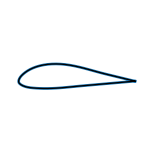

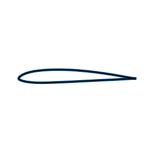

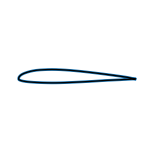

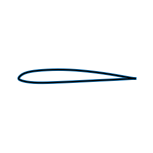

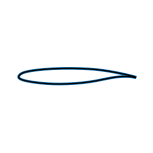

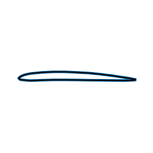

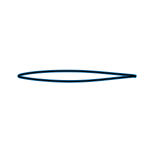

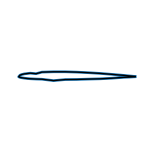

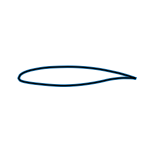

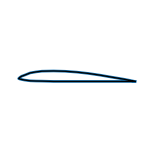

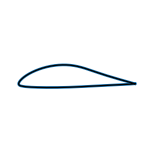

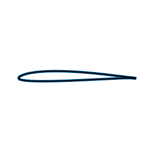

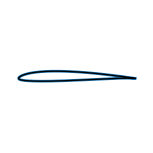

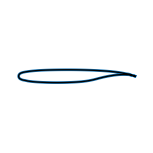

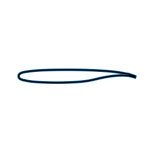

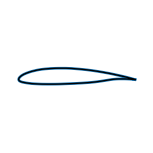

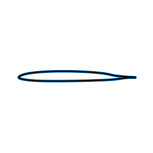

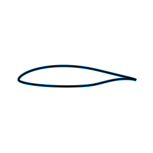

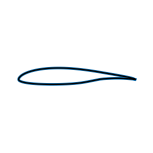

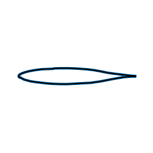

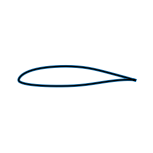

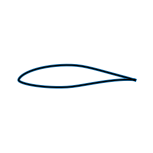

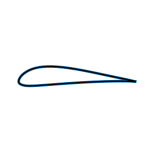

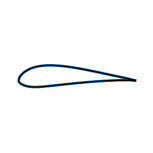

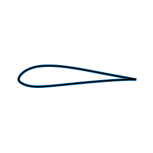

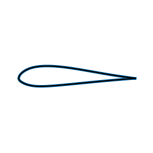

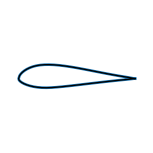

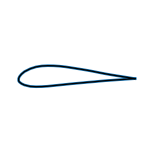

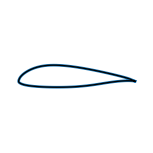

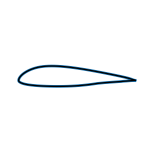

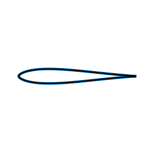

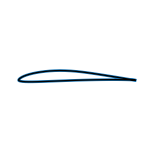

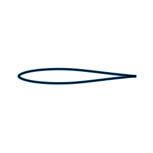

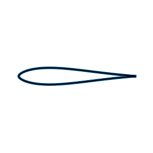

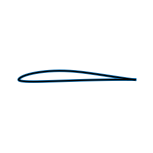

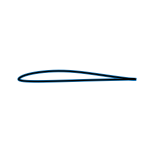

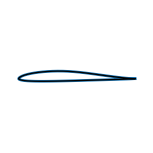

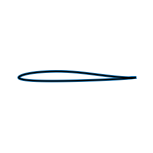

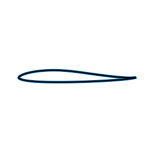

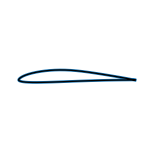

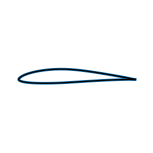

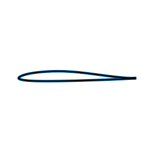

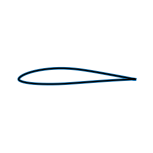

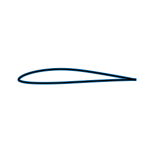

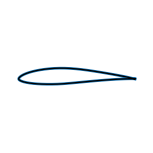

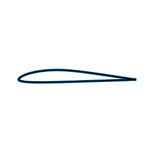

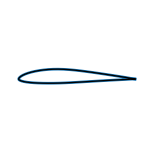

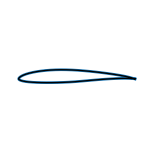

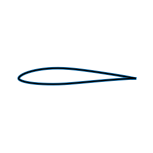

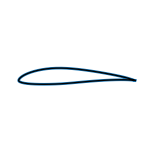

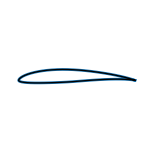

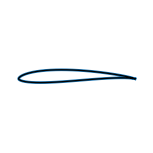

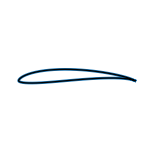

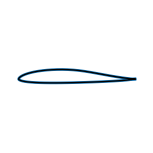

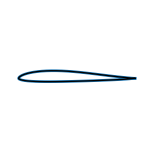

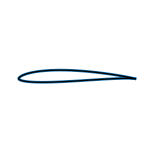

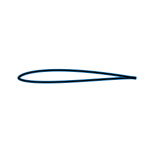

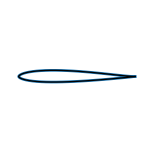

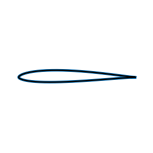

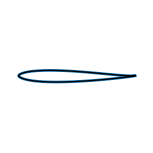

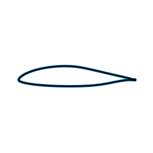

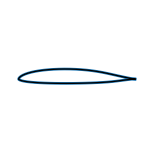

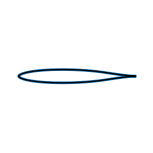

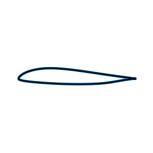

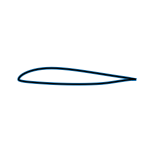

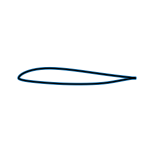

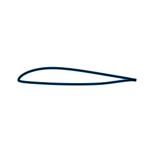

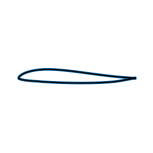

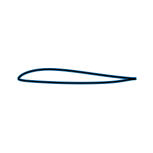

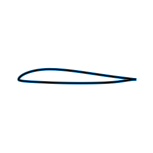

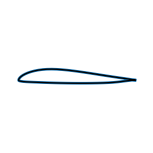

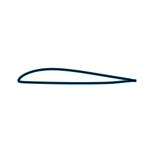

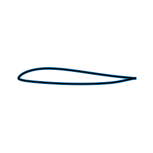

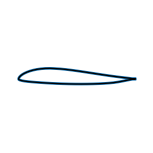

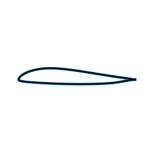

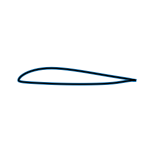

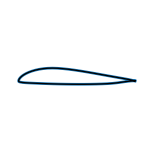

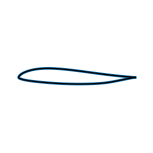

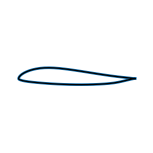

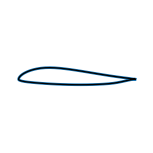

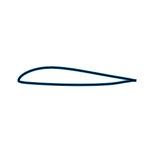

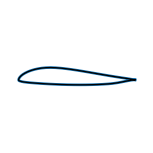

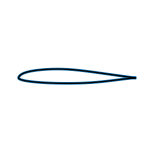

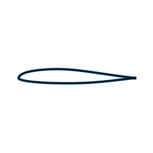

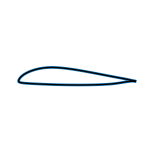

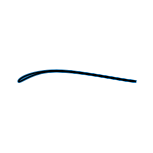

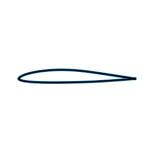

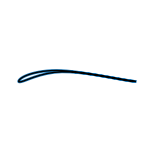

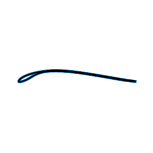

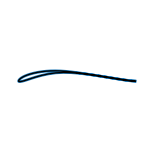

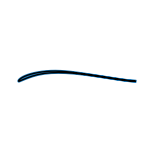

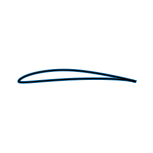

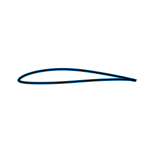

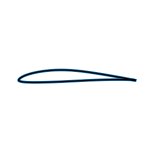

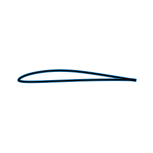

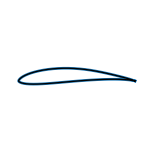

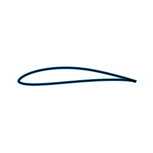

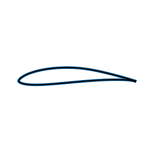

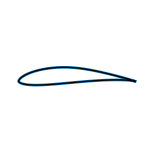

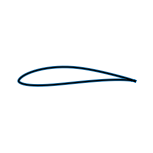

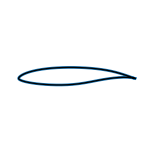

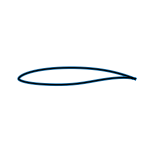

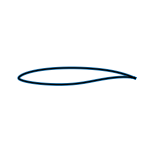

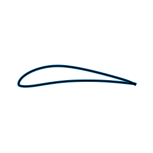

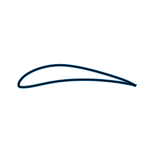

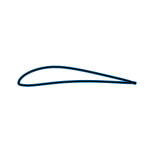

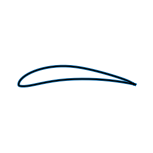

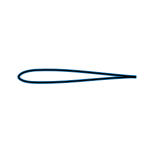

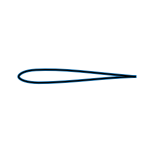

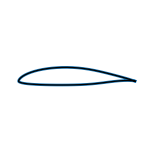

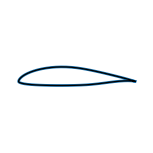

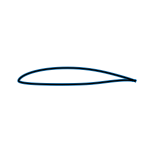

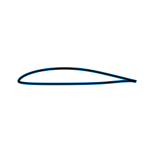

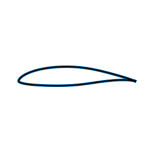

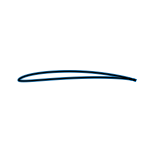

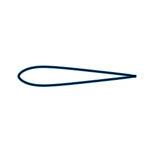

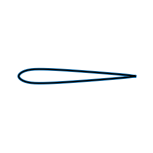

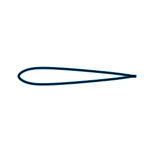

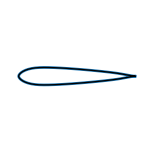

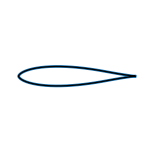

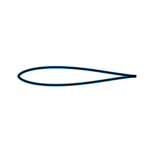

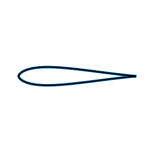

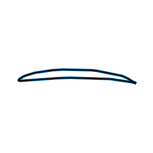

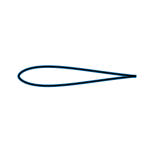

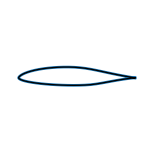

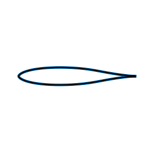

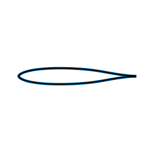

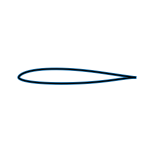

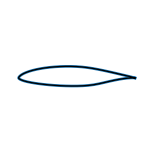

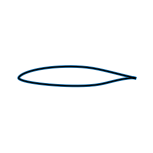

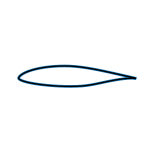

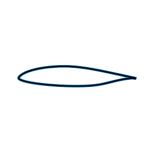

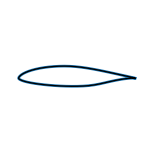

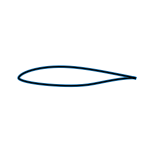

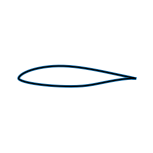

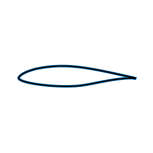

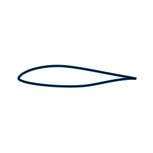

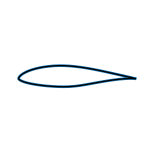

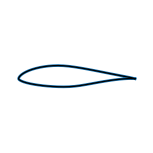

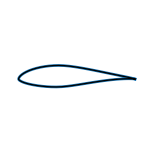

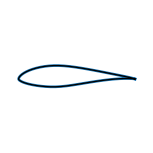

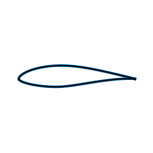

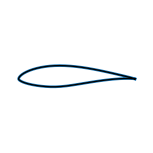

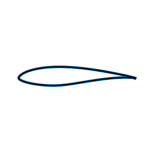

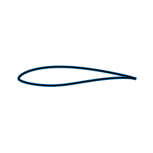

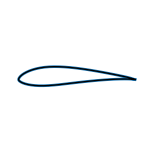

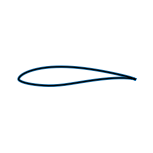

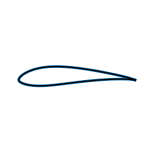

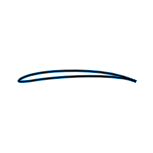

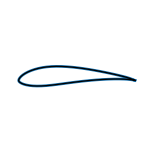

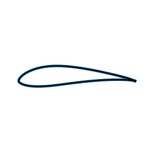

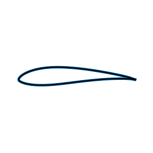

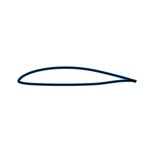

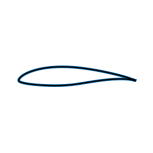

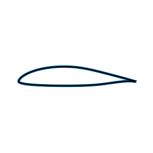

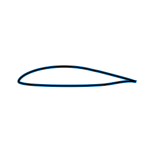

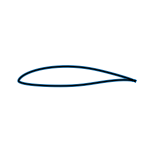

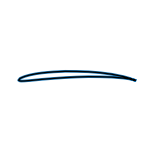

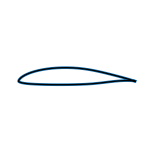

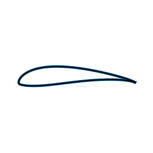

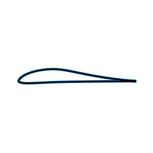

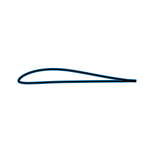

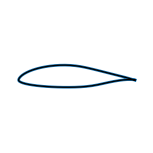

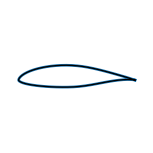

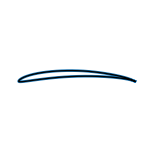

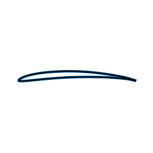

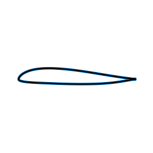

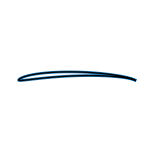

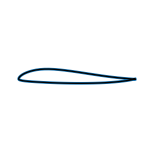

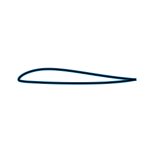

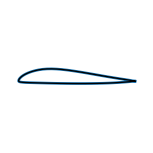

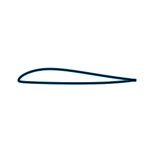

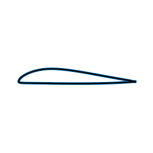

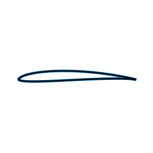

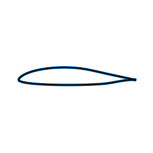

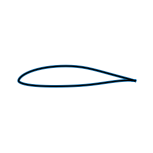

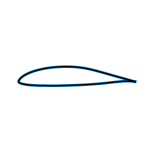

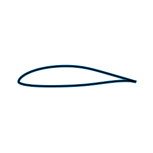

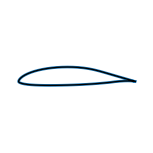

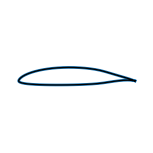

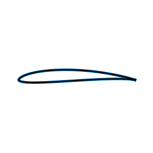

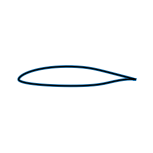

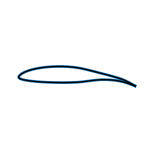

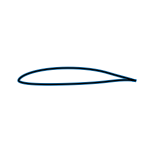

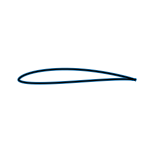

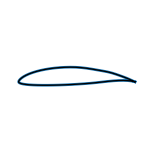

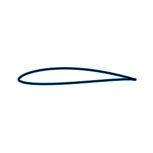

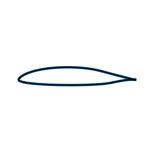

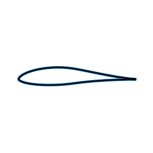

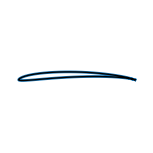

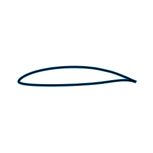

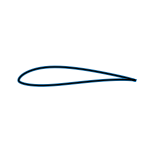

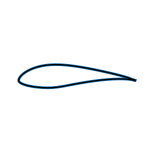

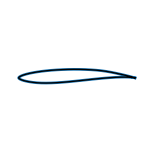

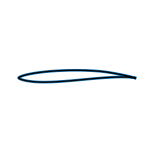

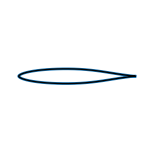

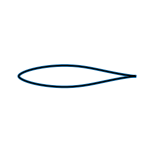

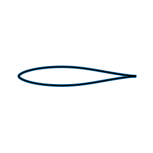

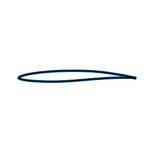

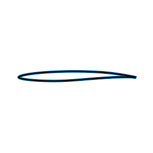

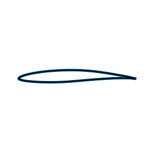

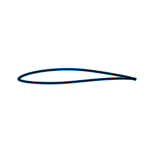

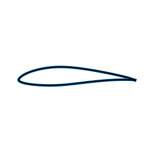

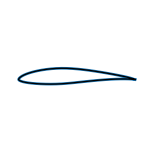

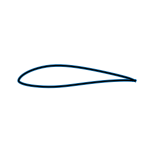

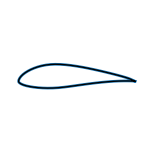

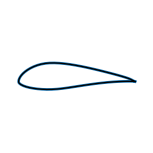

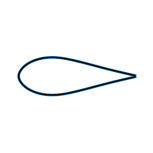

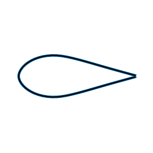

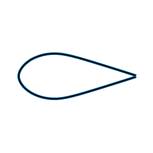

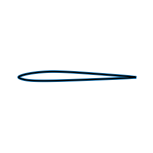

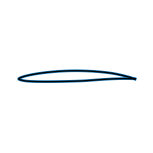

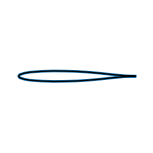

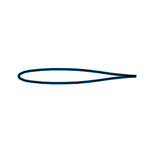

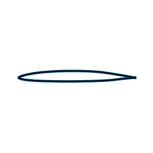

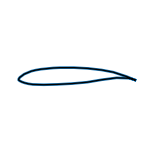

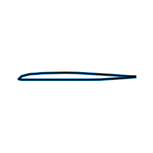

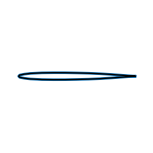

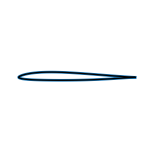

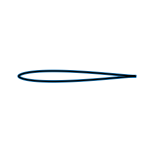

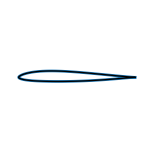

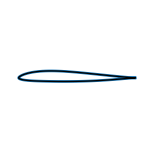

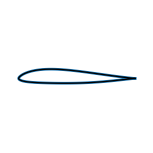

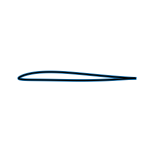

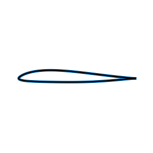

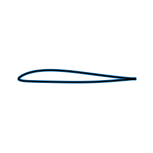

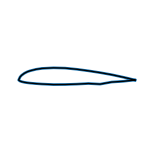

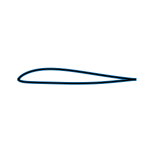

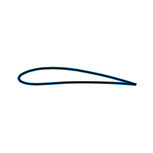

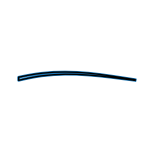

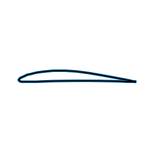

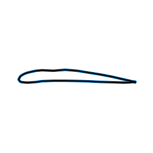

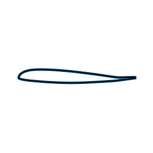

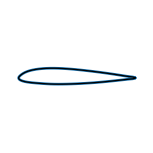

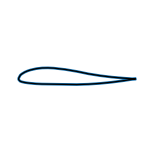

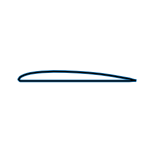

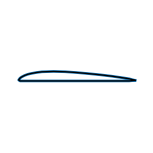

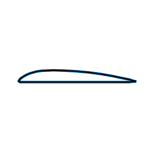

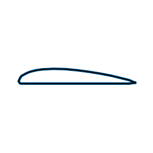

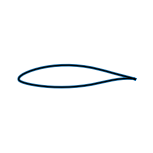

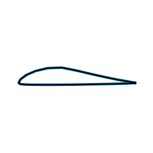

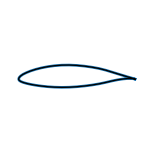

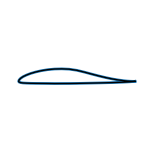

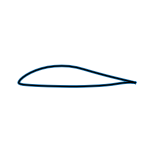

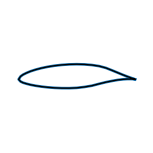

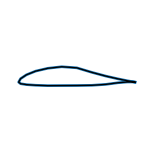

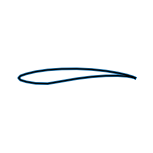

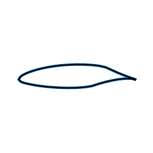

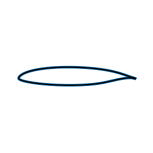

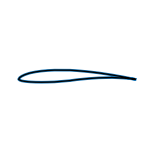

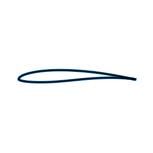

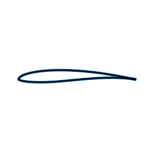

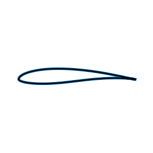

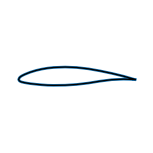

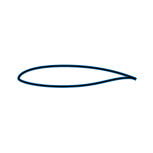

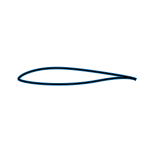

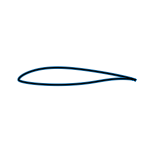

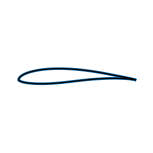

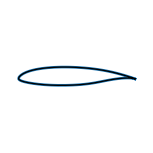

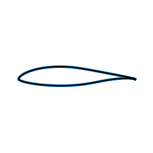

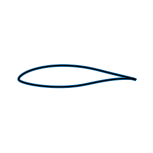

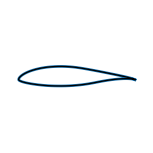

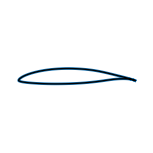

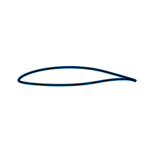

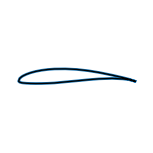

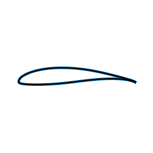

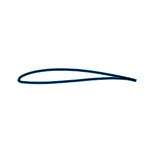

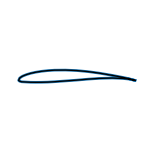

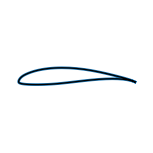

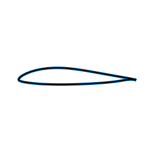

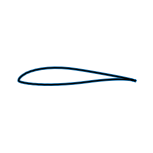

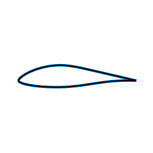

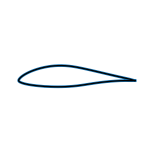

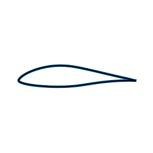

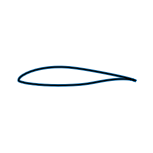

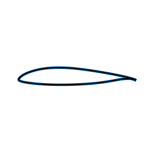

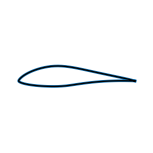

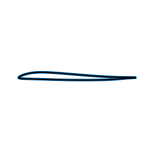

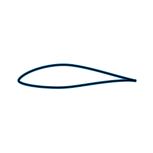

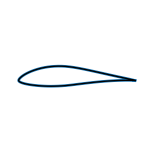

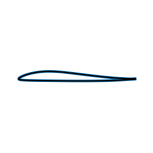

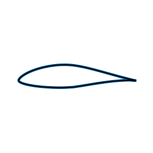

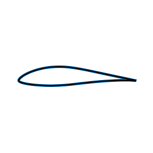

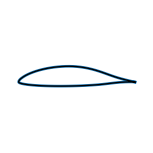

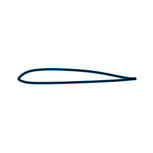

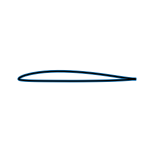

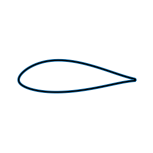

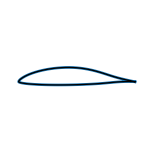

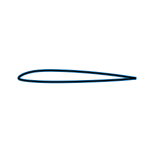

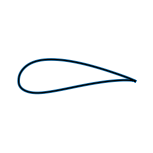

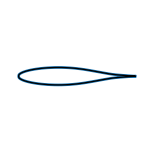

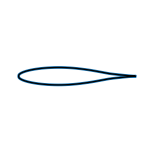

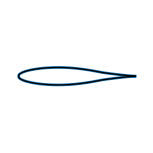

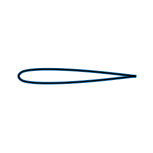

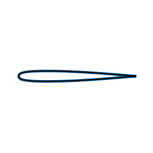

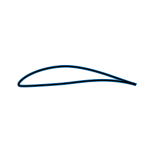

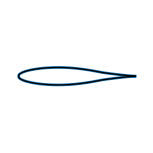

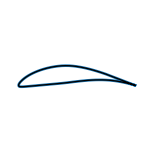

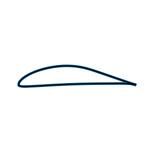

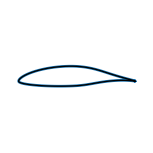

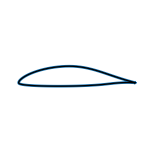

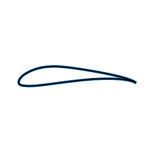

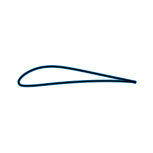

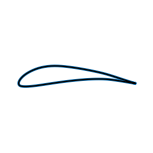

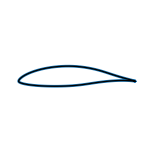

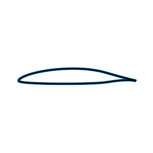

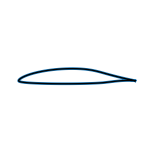

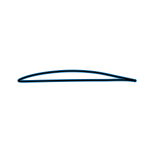

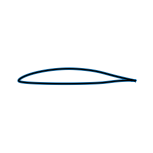

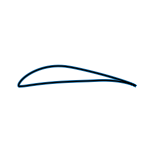

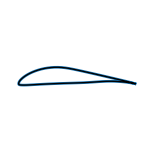

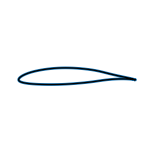

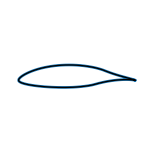

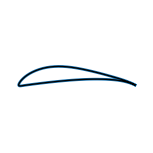

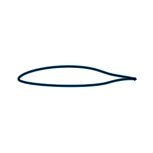

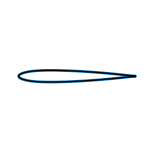

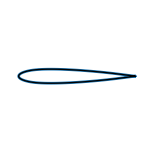

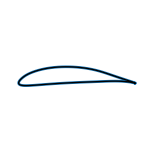

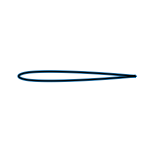

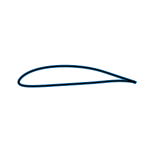

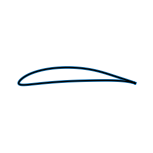

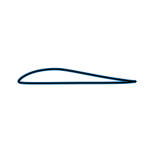

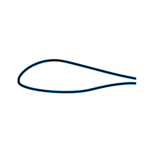

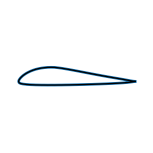

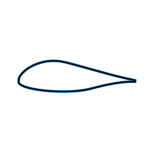

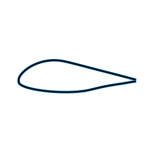

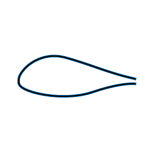

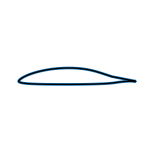

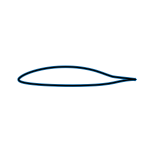

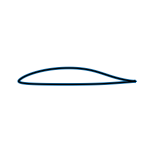

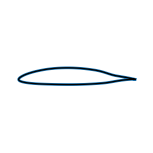

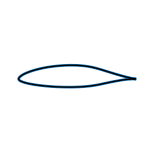

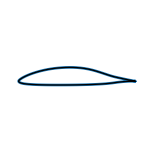

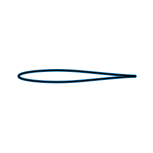

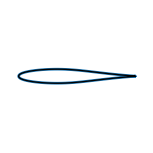

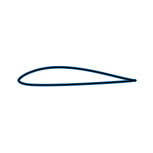

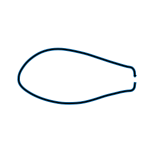

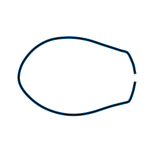

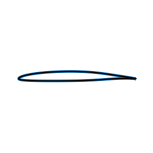

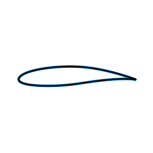

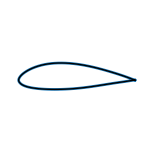

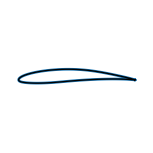

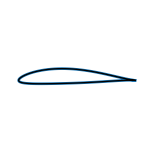

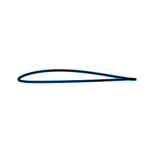

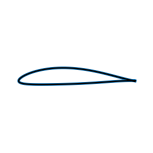

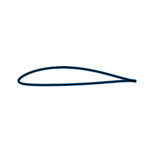

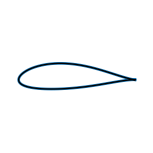

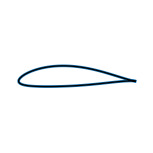

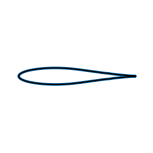

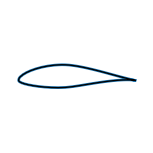

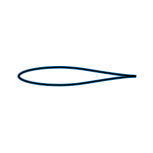

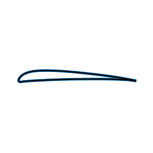

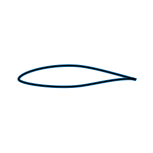

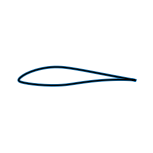

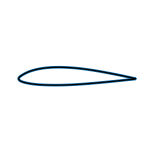

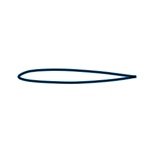

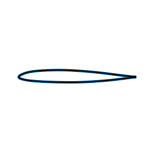

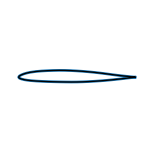

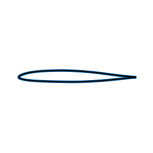

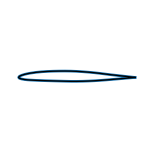

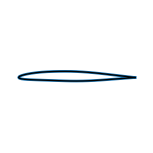

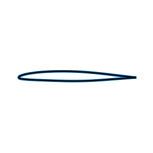

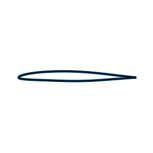

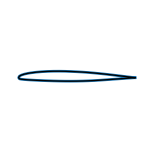

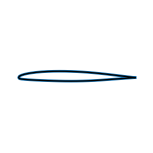

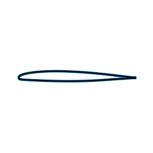

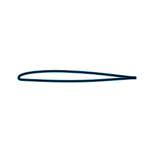

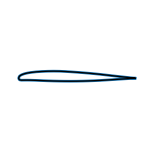

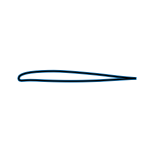

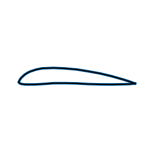

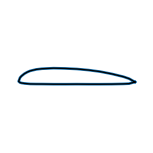

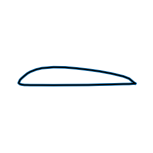

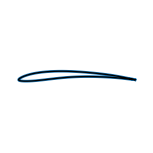

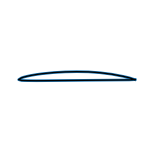

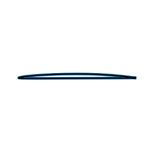

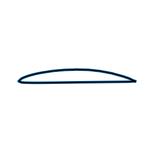

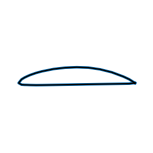

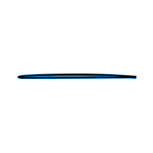

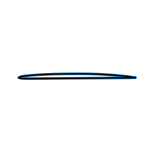

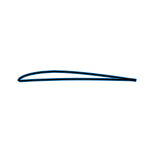

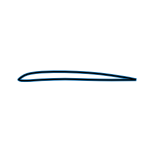

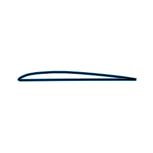

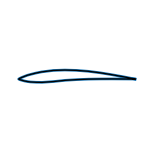

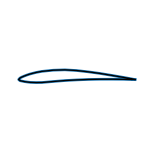

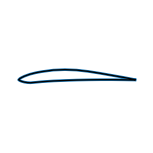

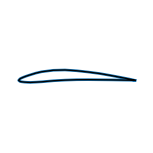

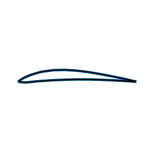

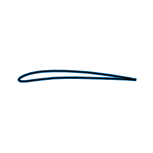

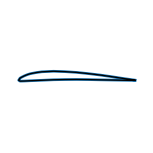

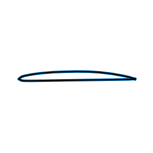

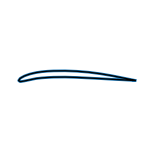

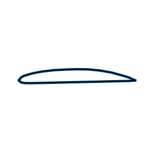

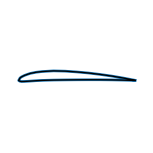

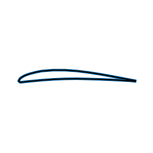

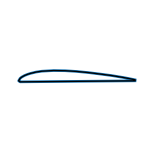

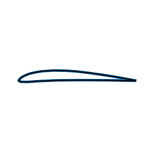

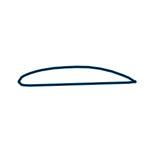

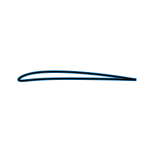

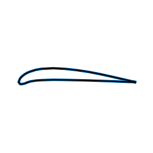

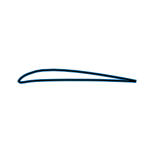

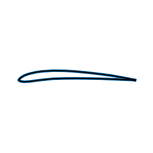

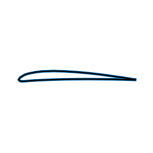

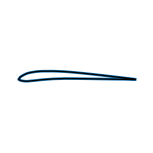

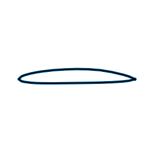

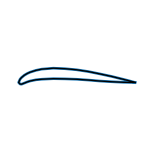

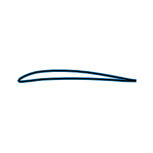

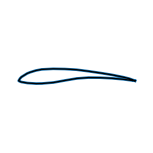

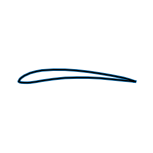

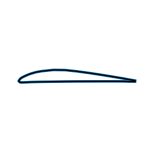

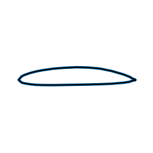

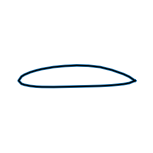

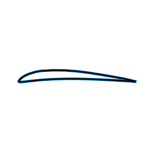

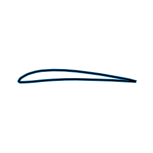

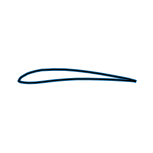

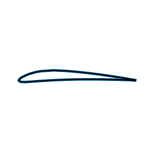

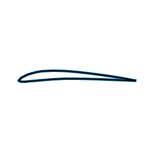

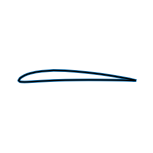

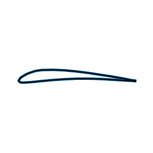

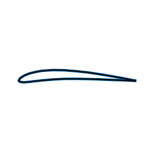

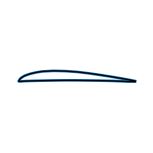

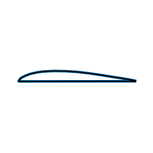

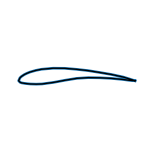

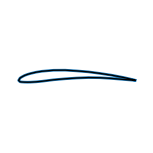

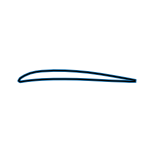

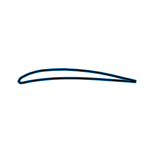

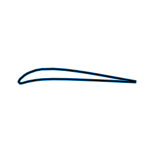

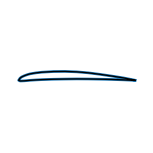

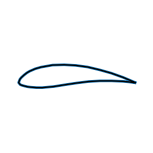

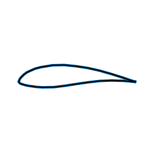

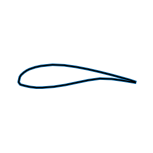

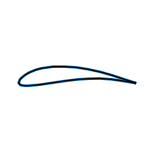

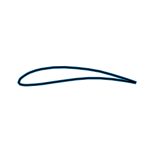

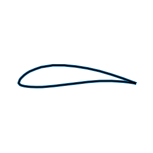

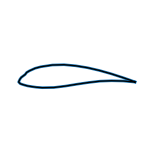

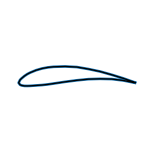

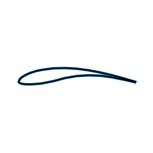

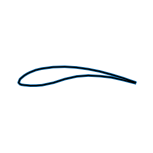

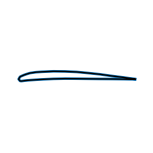

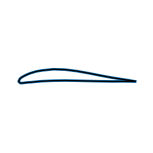

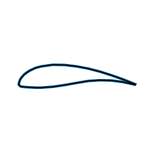

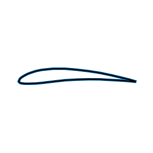

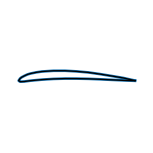

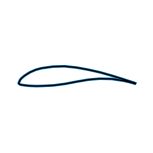

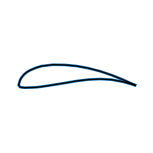

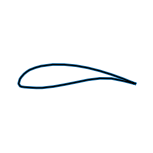

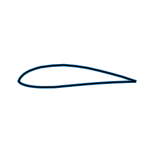

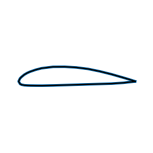

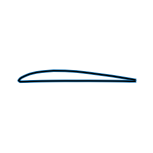

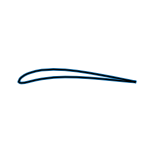

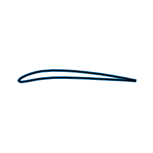

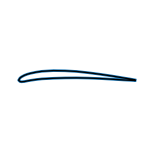

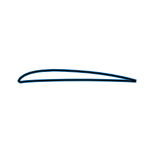

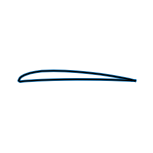

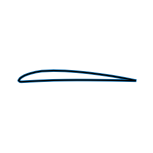

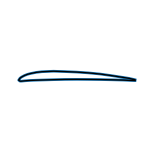

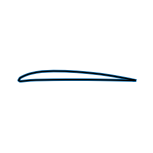

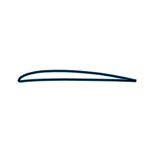

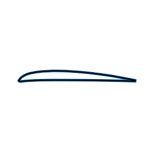

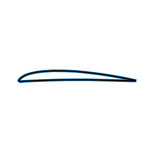

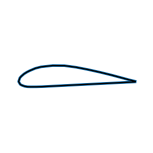

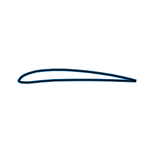

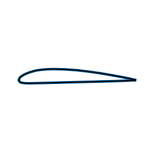

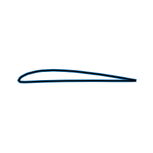

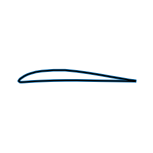

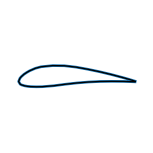

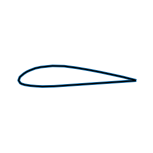

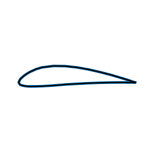

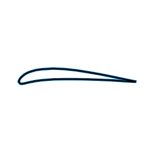

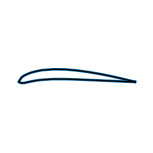

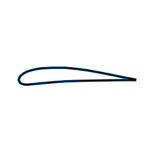

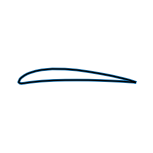

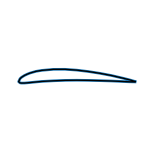

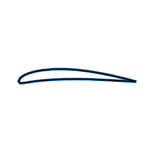

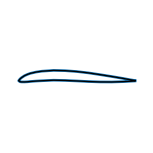

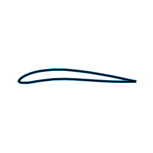

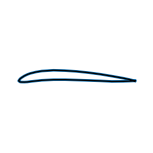

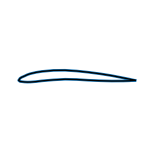

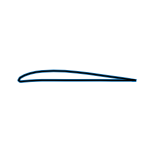

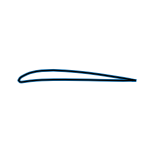

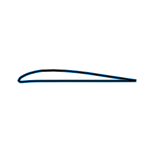

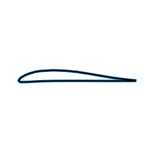

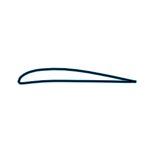

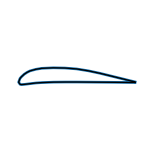

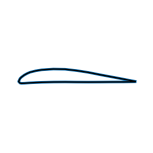

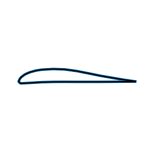

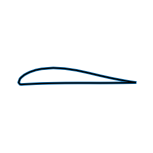

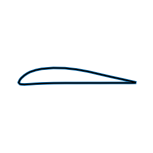

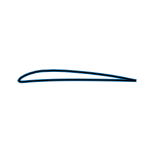

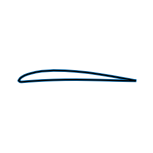

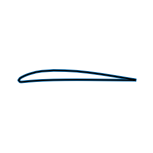

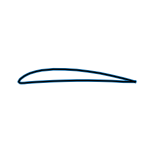

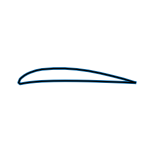

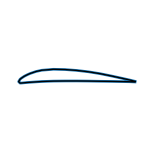

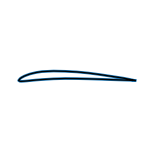

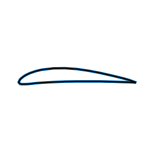

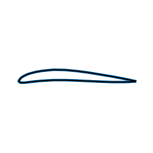

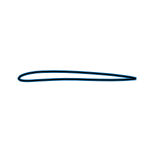

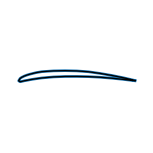

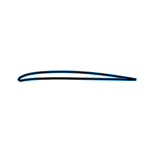

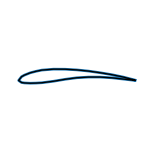

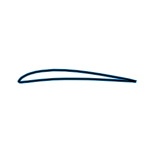

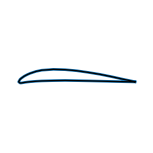

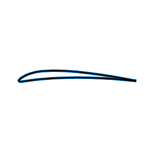

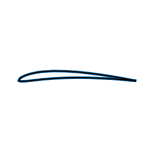

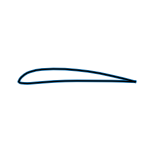

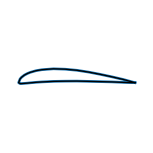

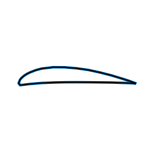

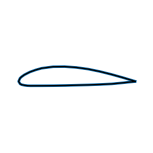

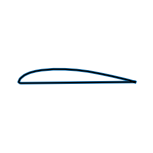

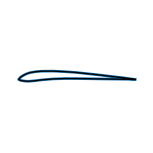

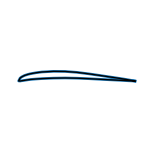

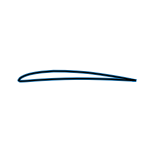

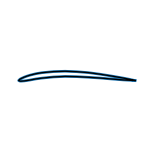

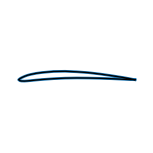

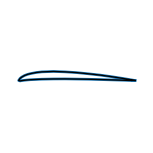

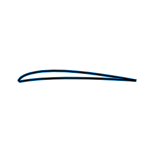

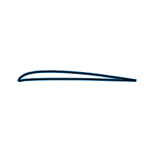

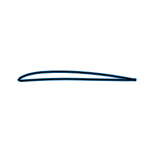

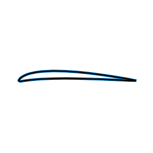

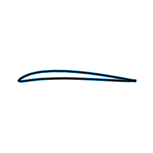

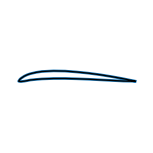

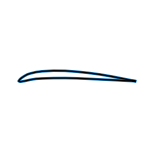

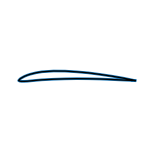

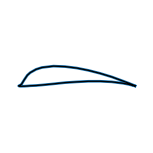

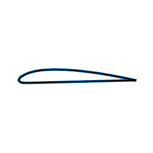

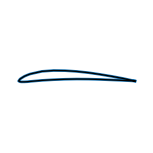

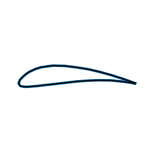

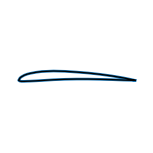

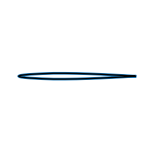

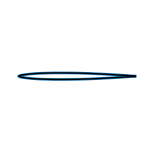

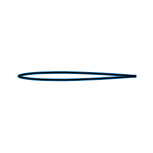

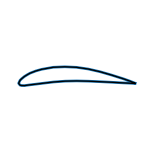

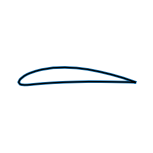

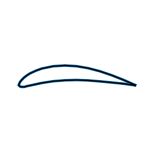

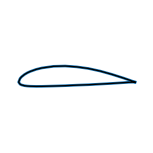

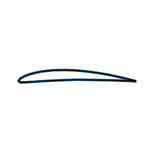

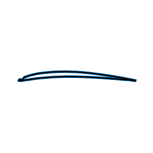

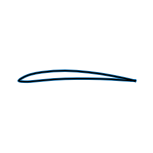

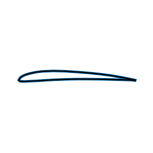

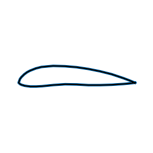

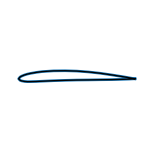

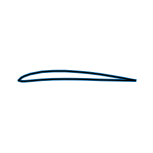

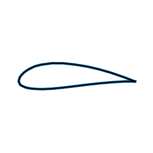

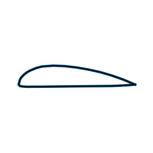

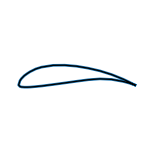

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/aeroo/data/coordinates/coord_seligFmt/.ipynb_checkpoints'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl
import os

dir_path = '/content/drive/MyDrive/aeroo/data/coordinates/coord_seligFmt/'
file_paths = []

for entry in os.listdir(dir_path):
  file_paths.append(os.path.join(dir_path, entry))


for e in range(len(file_paths)):
  file_path = file_paths[e]

  name = file_path[len(dir_path)-1: file_path.index('.')]
  df = pd.read_csv(file_path, sep='\t', comment="#")
  l = df.values.tolist()

  for i in range(len(l)):
    l[i] = str(l[i])
    l[i] = re.findall("[-+]?\d*\.\d+|\d+", l[i])

  for i in range(len(l)):
    l[i][0] = float(l[i][0])
    l[i][1] = float(l[i][1])

  x  = []
  y = []

  for i in range(len(l)):
    x.append(l[i][0])
    y.append(l[i][1])

  plt.figure(figsize=(5,5))
  plt.xticks(rotation=90)
  plt.plot(x, y)
  plt.axis('equal')
  plt.axis('off')
  mpl.rcParams['figure.figsize'] = [2, 2]
  mpl.rcParams['figure.dpi'] = 128
  fig = plt.gcf()

  plt.plot(x, y, 'k-', linewidth=0.75)
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  fig.set_size_inches(1, 1)
  plt.savefig('/content/drive/MyDrive/aeroo/data/images'+name+'.png', dpi=128)

  plt.show()

In [ ]:
import pandas as pd
import os
import numpy as np


image_dir = '/content/drive/MyDrive/aeroo/data/images/'
coord_dir = '/content/drive/MyDrive/aeroo/data/coordinates/coord_seligFmt/'


pngs = [f for f in os.listdir(image_dir) if f.endswith('.png')]

labels = []
for png in pngs:
    name = png.replace('.png', '')
    dat_path = os.path.join(coord_dir, f"{name}.dat")

    if not os.path.exists(dat_path):

        continue


    with open(dat_path, 'r') as f:
        lines = f.readlines()
    x, y = [], []
    for line in lines:
        if ' ' in line:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                except:
                    pass

    x = np.array(x)
    y = np.array(y)


    thickness = 0
    for i in range(len(x)):
        upper = np.max(y[x == x[i]])
        lower = np.min(y[x == x[i]])
        thickness = max(thickness, (upper - lower) * 100)


    cl_max = np.clip(0.01 * thickness + np.random.normal(1.1, 0.2), 0.8, 1.8)

    labels.append({'filename': png, 'cl_max': round(cl_max, 3)})


df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/aeroo/data/labels.csv', index=False)

print("STEP 2 DONE")
print(f"Images: {len(pngs)}")
print(f"Labels: {len(df)} rows ")
print("First 5:")
print(df.head())
print("\ncl_max:", df['cl_max'].describe())

STEP 2 DONE
Images: 999
Labels: 999 rows (realistic cl_max from thickness)
Sample (first 5):
    filename  cl_max
0  raf33.png   0.938
1  raf34.png   1.351
2  raf48.png   1.208
3   raf6.png   1.183
4  raf69.png   1.436

cl_max stats: count    999.000000
mean       1.164063
std        0.211057
min        0.800000
25%        1.016500
50%        1.153000
75%        1.306500
max        1.800000
Name: cl_max, dtype: float64


In [ ]:
import pandas as pd
import requests
import re
import os


url = 'https://m-selig.ae.illinois.edu/uiuc_lsat/LSAT-VOL1-SUMMARY.txt'
response = requests.get(url)
text = response.text


cl_data = {}
lines = text.split('\n')
for line in lines:
    if 'cl_max' in line.lower():
        match = re.search(r'(.+?):\s*cl_max\s*=\s*([\d.]+)', line, re.IGNORECASE)
        if match:
            name = match.group(1).strip().lower().replace(' ', '').replace('-', '')
            cl = float(match.group(2))
            cl_data[name] = cl

print(f"Parsed {len(cl_data)} real cl_max from LSAT Vol 1")


image_dir = '/content/drive/MyDrive/aeroo/data/images/'
pngs = [f for f in os.listdir(image_dir) if f.endswith('.png')]


labels = []
for png in pngs:
    name = png.replace('.png', '').replace('-', '').replace(' ', '').lower()
    if name in cl_data:
        cl_max = cl_data[name]
        print(f"Real match: {png} → cl_max={cl_max}")
    else:
        cl_max = 1.1
    labels.append({'filename': png, 'cl_max': round(cl_max, 3)})

df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/aeroo/data/labels.csv', index=False)
print(f"\nlabels.csv updated: {len(df)} rows (80+ real cl_max)")
print(df.head())

Parsed 0 real cl_max from LSAT Vol 1

labels.csv updated: 999 rows (80+ real cl_max)
    filename  cl_max
0  raf33.png     1.1
1  raf34.png     1.1
2  raf48.png     1.1
3   raf6.png     1.1
4  raf69.png     1.1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

fname = '/content/drive/MyDrive/aeroo/data/labels.csv'
df = pd.read_csv(fname)


df = df.dropna(subset=['cl_max']).reset_index(drop=True)
print(f"Total clean samples: {len(df)}")

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

Total clean samples: 999
Train: 799, Val: 200


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5, zoom_range=0.1)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/drive/MyDrive/aeroo/data/images/',
    x_col='filename', y_col='cl_max',
    target_size=(224,224), batch_size=32,
    class_mode='raw', shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory='/content/drive/MyDrive/aeroo/data/images/',
    x_col='filename', y_col='cl_max',
    target_size=(224,224), batch_size=32,
    class_mode='raw', shuffle=False
)

Found 799 validated image filenames.
Found 200 validated image filenames.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

print("Training started...")
model.fit(train_gen, validation_data=val_gen, epochs=5)

model.save('/content/drive/MyDrive/aeroo/airfoil_cnn_model.h5')
print("Model saved!")

Training started...
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 952ms/step - loss: 3.1338 - mae: 1.6870 - val_loss: 1.8059 - val_mae: 1.3436
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 491ms/step - loss: 1.5405 - mae: 1.1246 - val_loss: 0.7165 - val_mae: 0.8459
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 496ms/step - loss: 0.7373 - mae: 0.7330 - val_loss: 0.2295 - val_mae: 0.4777
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - loss: 0.3743 - mae: 0.4966 - val_loss: 0.0552 - val_mae: 0.2317
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - loss: 0.2856 - mae: 0.4229 - val_loss: 0.0120 - val_mae: 0.1058


Model saved!


Saving e.png to e.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


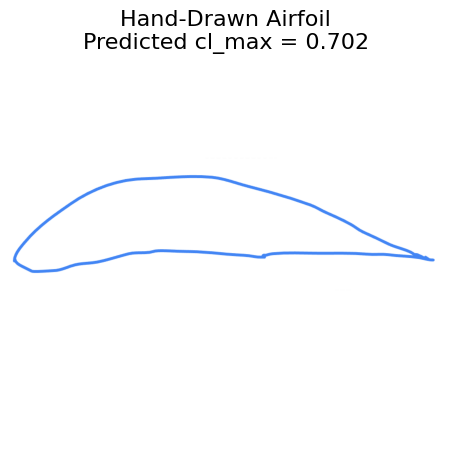

cl_max = 0.702


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred_cl = model.predict(img_array)[0][0]


plt.figure(figsize=(6,5))
plt.imshow(plt.imread(img_path))
plt.title(f"Hand-Drawn Airfoil\nPredicted cl_max = {pred_cl:.3f}", fontsize=16)
plt.axis('off')
plt.show()

print(f"cl_max = {pred_cl:.3f}")

In [ ]:
from sklearn.metrics import mean_absolute_error

val_preds = model.predict(val_gen).flatten()
mae = mean_absolute_error(val_df['cl_max'], val_preds)
print(f"\nFINAL MAE = {mae:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 823ms/step

FINAL MAE = 0.1058
